課題内容：価値反復法のアルゴリズムであるQ学習により，迷路を探索する．

---
#### 参考書籍
「つくりながら学ぶ！深層強化学習」，著者：株式会社電通国際情報サービス 小川雄太郎，出版社：マイナビ出版</br>

#### サポートリポジトリ
https://github.com/YutaroOgawa/Deep-Reinforcement-Learning-Book/tree/master

#### 変更点
- 状態（迷路）の拡張
    - 変更前：3×3の9つの状態
    - 変更後：5×5の25つの状態 
- 報酬の変更
    - 変更前：ロボットがゴールに到達したら報酬を+1与えるのみ．
    - 変更後：ロボットがゴールに到達したら報酬を+1与える．ロボットが移動するたびに報酬を-0.05与える．（これにより，ロボットが最短経路でゴールに到達できる可能性がある．）
- ロボットが移動するアニメーションの追加
    - 状態価値に対応したロボットの行動を可視化する処理を追加

---

In [48]:
# 使用するパッケージ
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### 5×5の迷路の描画
迷路の説明
- s0~s24は状態sを表す
- 緑の丸はロボットを表す（向きは考慮しない）
- 赤い線は壁でロボットは通れない
- s0がスタート地点であり，s24を目指す

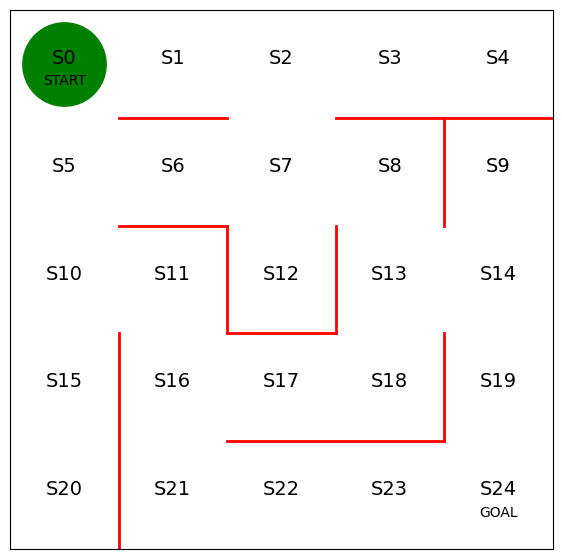

In [49]:
# 図の大きさと図の変数名
fig = plt.figure(figsize=(7, 7))
ax = plt.gca()

# 赤い壁
plt.plot([1, 2], [4, 4], color='red', linewidth=2)
plt.plot([3, 5], [4, 4], color='red', linewidth=2)
plt.plot([3, 3], [2, 3], color='red', linewidth=2)
plt.plot([1, 2], [3, 3], color='red', linewidth=2)
plt.plot([2, 3], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 3], color='red', linewidth=2)
plt.plot([4, 4], [4, 3], color='red', linewidth=2)
plt.plot([4, 4], [2, 1], color='red', linewidth=2)
plt.plot([2, 4], [1, 1], color='red', linewidth=2)
plt.plot([1, 1], [2, 0], color='red', linewidth=2)

# 状態を示す文字（S0~S24）
plt.text(0.5, 4.5, 'S0', size=14, ha='center')
plt.text(1.5, 4.5, 'S1', size=14, ha='center')
plt.text(2.5, 4.5, 'S2', size=14, ha='center')
plt.text(3.5, 4.5, 'S3', size=14, ha='center')
plt.text(4.5, 4.5, 'S4', size=14, ha='center')
plt.text(0.5, 3.5, 'S5', size=14, ha='center')
plt.text(1.5, 3.5, 'S6', size=14, ha='center')
plt.text(2.5, 3.5, 'S7', size=14, ha='center')
plt.text(3.5, 3.5, 'S8', size=14, ha='center')
plt.text(4.5, 3.5, 'S9', size=14, ha='center')
plt.text(0.5, 2.5, 'S10', size=14, ha='center')
plt.text(1.5, 2.5, 'S11', size=14, ha='center')
plt.text(2.5, 2.5, 'S12', size=14, ha='center')
plt.text(3.5, 2.5, 'S13', size=14, ha='center')
plt.text(4.5, 2.5, 'S14', size=14, ha='center')
plt.text(0.5, 1.5, 'S15', size=14, ha='center')
plt.text(1.5, 1.5, 'S16', size=14, ha='center')
plt.text(2.5, 1.5, 'S17', size=14, ha='center')
plt.text(3.5, 1.5, 'S18', size=14, ha='center')
plt.text(4.5, 1.5, 'S19', size=14, ha='center')
plt.text(0.5, 0.5, 'S20', size=14, ha='center')
plt.text(1.5, 0.5, 'S21', size=14, ha='center')
plt.text(2.5, 0.5, 'S22', size=14, ha='center')
plt.text(3.5, 0.5, 'S23', size=14, ha='center')
plt.text(4.5, 0.5, 'S24', size=14, ha='center')
plt.text(0.5, 4.3, 'START', ha='center')
plt.text(4.5, 0.3, 'GOAL', ha='center')

# 描画範囲と目盛り削除
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

# S0に緑色の丸を描画
line, = ax.plot([0.5], [4.5], marker='o', color='g', markersize=60)

#### 初期の方策
初期の方策πを決定するパラメータtheta_0を表形式表現で設定する．行動aは以下に示す4つであるが，迷路に壁があるので，それぞれの状態によって行動は異なる．
- 上へ移動
- 右へ移動
- 下へ移動
- 左へ移動

In [50]:
# 初期の方策を決定するパラメータtheta_0を設定

# 表形式表現：行は状態s（S0〜S24）を，列は行動a（↑，→，↓，←）を表す
theta_0 = np.array([[np.nan, 1, 1, np.nan],         # s0
                    [np.nan, 1, np.nan, 1],         # s1
                    [np.nan, 1, 1, 1],              # s2
                    [np.nan, 1, 1, np.nan],         # s3
                    [np.nan, np.nan, np.nan, 1],    # s4
                    [1, 1, 1, np.nan],              # s5
                    [np.nan, 1, np.nan, 1],         # s6
                    [1, 1, 1, 1],                   # s7
                    [np.nan, np.nan, 1, 1],         # s8
                    [np.nan, np.nan, 1, np.nan],    # s9
                    [1, 1, 1, np.nan],              # s10
                    [np.nan, np.nan, 1, 1],         # s11
                    [1, np.nan, np.nan, np.nan],    # s12
                    [1, 1, 1, np.nan],              # s13
                    [1, np.nan, 1, 1],              # s14
                    [1, np.nan, 1, np.nan],         # s15
                    [1, 1, 1, np.nan],              # s16
                    [np.nan, 1, np.nan, 1],         # s17
                    [1, np.nan, np.nan, 1],         # s18
                    [1, np.nan, 1, np.nan],         # s19
                    [1, np.nan, np.nan, np.nan],    # s20
                    [1, 1, np.nan, np.nan],         # s21
                    [np.nan, 1, np.nan, 1],         # s22
                    [np.nan, 1, np.nan, 1],         # s23
                    ])                              # s24はゴールなので方策なし

#### 割合に変換
上記のthera_0を単純な割合に変換する．例えば，状態s0であれば行動は2つ（右へ移動，下へ移動）なので，[0, 0.5, 0.5, 0]（↑，→，↓，←）となる．

In [51]:
# 方策パラメータtheta_0をランダム方策piに変換する関数

def simple_convert_info_pi_from_theta(theta):
    [m, n] = theta.shape    #thetaの行列サイズを取得
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :]) # 割合の計算
        
    pi = np.nan_to_num(pi)  #nanを0に変換

    return pi

# ランダム行動方策pi_0を求める
pi_0 = simple_convert_info_pi_from_theta(theta_0)
# 初期の方策pi_0を表示
print(pi_0)

[[0.         0.5        0.5        0.        ]
 [0.         0.5        0.         0.5       ]
 [0.         0.33333333 0.33333333 0.33333333]
 [0.         0.5        0.5        0.        ]
 [0.         0.         0.         1.        ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.5        0.         0.5       ]
 [0.25       0.25       0.25       0.25      ]
 [0.         0.         0.5        0.5       ]
 [0.         0.         1.         0.        ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.         0.5        0.5       ]
 [1.         0.         0.         0.        ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.33333333 0.         0.33333333 0.33333333]
 [0.5        0.         0.5        0.        ]
 [0.33333333 0.33333333 0.33333333 0.        ]
 [0.         0.5        0.         0.5       ]
 [0.5        0.         0.         0.5       ]
 [0.5        0.         0.5        0.        ]
 [1.         0.         0.         0.        ]
 [0.5        

#### 行動価値関数Q
価値反復法で使用する行動価値関数Qを表形式表現で実装する．正しい行動価値はわからないので，初期状態ではランダムな値を与える．

In [52]:
# 初期の行動価値関数Q

[a, b] = theta_0.shape  # 行と列の数をa,bに格納
Q = np.random.rand(a, b) * theta_0 * 0.1
# theta_0を掛けることで，生成した乱数のうち壁方向に対応するものをnp.nanにする
# 初期のQ値を小さくするため0.1を掛ける（描画しやすく）

#### ε-greedy法
各時刻で行動aを行動価値関数Qから求める方策を実装する．ここでは，一定の確率εでランダムに行動し，残りの1-εの確率で行動価値Qが最大になる行動を採用するε-greedy法を用いる．

In [53]:
# ε-greedy法


def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    # 行動を決める
    if np.random.rand() < epsilon:
        # εの確率でランダムに動く
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # Qの最大値の行動を採用する
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 行動をindexに
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3

    return action


def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]   # 行動aの方向

    # 行動から次の状態を決める
    if next_direction == "up":
        s_next = s - 5  # 上に移動するときは状態の数字が5小さくなる
    elif next_direction == "right":
        s_next = s + 1  # 右に移動するときは状態の数字が1大きくなる
    elif next_direction == "down":
        s_next = s + 5  # 下に移動するときは状態の数字が5大きくなる
    elif next_direction == "left":
        s_next = s - 1  # 左に移動するときは状態の数字が1小さくなる

    return s_next

#### 行動価値関数Qの更新
行動価値関数Qが正しい値になるように更新し，学習する処理を実装する．Q学習では，行動価値関数Qが方策に依存しない（方策オフ型）ので，ε-greedy法から生まれるランダム性が更新式に入力されない．

In [54]:
# Q学習による行動価値関数Qの更新

def Q_learning(s, a, r, s_next, Q, eta, gamma):

    if s_next == 24: #ゴールした場合
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])

    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next, :]) - Q[s, a])

    return Q

#### Q学習で迷路を解く
ロボットが1マス移動するたびに1ステップかかるとする．また，ロボットがスタートからゴールに到達するまでを1エピソードとする．ここでは，最大100エピソード学習させ，それぞれ1エピソードごとに，ゴールするまでにかかったステップ数と状態価値関数の変化を表示する．報酬は以下の値に設定した．

報酬
- ゴールに到達したら+1与える
- 1ステップごと（ロボットが動くたび）に-0.05与える

In [55]:
# Q学習で迷路を解く関数の定義，状態と行動の履歴および更新したQを出力

def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0   #スタート地点
    a = a_next = get_action(s, Q, epsilon, pi)  #初期の行動
    s_a_history = [[0, np.nan]] # エージェントの移動を記録するリスト

    while (1):
        a = a_next  #行動の更新

        s_a_history[-1][1] = a
        # 現在の状態（一番最後なのでindex=-1）に行動を代入

        s_next = get_s_next(s, a, Q, epsilon, pi)
        # 次の状態を格納

        s_a_history.append([s_next, np.nan])
        # 次の状態を代入．行動はまだわからないのでnan

        # 報酬を与え，次の行動を求める
        if s_next == 24:
            r = 1   # ゴールに到達したら報酬を与える
            a_next = np.nan
        else :
            r = -0.05  # 行動するたびに負の報酬を与える#########################################################
            a_next = get_action(s_next, Q, epsilon, pi)
            # 次の行動a_nextを求める

        # 価値関数を更新
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma)

        # 終了判定
        if s_next == 24: # ゴール地点なら終了
            break
        else:
            s = s_next

    return [s_a_history, Q]


# Q学習で迷路を解く

eta = 0.1   # 学習率
gamma = 0.9 # 時間割引率
epsilon = 0.5   # ε-greedy法の初期値
v = np.nanmax(Q, axis=1)    # 状態ごとに価値の最大値を求める
is_continue = True
episode = 1

V = []  # エピソードごとの状態価値を格納する
V.append(np.nanmax(Q, axis=1))  # 状態ごとに行動価値の最大値を求める

while is_continue:  # is_continueがFalseになるまで繰り返す
    print("エピソード：" + str(episode))

    # ε-greedyの値を少しずつ小さくする
    epsilon = epsilon / 2

    # Q学習で迷路を解き，移動した履歴と更新したQを求める
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    # 状態価値の変化
    new_v = np.nanmax(Q, axis=1)    # 状態ごとに行動価値の最大値を求める
    print(np.sum(np.abs(new_v- v))) # 状態価値関数の変化を出力
    v = new_v
    V.append(v) # このエピソード終了時の状態価値関数を追加

    print("迷路を解くのにかかったステップ数は" + str(len(s_a_history) - 1) + "です")

    # 100エピソード繰り返す
    episode += 1
    if episode > 100:
        break

エピソード：1
0.3875128786512939
迷路を解くのにかかったステップ数は72です
エピソード：2
0.4439563525870922
迷路を解くのにかかったステップ数は116です
エピソード：3
0.14804205578363916
迷路を解くのにかかったステップ数は22です
エピソード：4
0.19999639463397653
迷路を解くのにかかったステップ数は38です
エピソード：5
0.10739534462467767
迷路を解くのにかかったステップ数は10です
エピソード：6
0.11161386120482447
迷路を解くのにかかったステップ数は18です
エピソード：7
0.10601545269506439
迷路を解くのにかかったステップ数は14です
エピソード：8
0.1067012012577262
迷路を解くのにかかったステップ数は16です
エピソード：9
0.10289729164614371
迷路を解くのにかかったステップ数は14です
エピソード：10
0.27227635268654626
迷路を解くのにかかったステップ数は70です
エピソード：11
0.08893375681844339
迷路を解くのにかかったステップ数は12です
エピソード：12
0.08172302722971891
迷路を解くのにかかったステップ数は10です
エピソード：13
0.1290320022694701
迷路を解くのにかかったステップ数は20です
エピソード：14
0.11306564649788894
迷路を解くのにかかったステップ数は24です
エピソード：15
0.08212635681211086
迷路を解くのにかかったステップ数は12です
エピソード：16
0.11400812940525507
迷路を解くのにかかったステップ数は24です
エピソード：17
0.09188738146868151
迷路を解くのにかかったステップ数は14です
エピソード：18
0.0809788292268616
迷路を解くのにかかったステップ数は10です
エピソード：19
0.08266868624050991
迷路を解くのにかかったステップ数は10です
エピソード：20
0.08380843581251138
迷路を解くのにかかったステップ

#### Q学習による状態価値の変化
Q学習による状態価値関数の変化を以下に示す．濃い赤色ほど状態価値が高いことを表し，濃い青色ほど状態価値が低いことを表している．最初は，ゴールであるs24のみ価値が高いため，s24だけが濃い赤色でその他のマスは青色であることがわかる．また，学習が進むにつれて，ゴールであるs24から徐々に価値が高くなっていることがわかる．

In [56]:
# 状態価値の変化を可視化
# 参考URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm  # color map


def init():
    # 背景画像の初期化
    line.set_data([], [])
    return (line,)


def animate(i):
    # フレームごとの描画内容
    # 各マスに状態価値の大きさに基づく色付きの四角を描画
    line, = ax.plot([0.5], [4.5], marker="s", color=cm.jet(V[i][0]), markersize=70) # S0
    line, = ax.plot([1.5], [4.5], marker="s", color=cm.jet(V[i][1]), markersize=70) # S1
    line, = ax.plot([2.5], [4.5], marker="s", color=cm.jet(V[i][2]), markersize=70) # S2
    line, = ax.plot([3.5], [4.5], marker="s", color=cm.jet(V[i][3]), markersize=70) # S3
    line, = ax.plot([4.5], [4.5], marker="s", color=cm.jet(V[i][4]), markersize=70) # S4
    line, = ax.plot([0.5], [3.5], marker="s", color=cm.jet(V[i][5]), markersize=70) # S5
    line, = ax.plot([1.5], [3.5], marker="s", color=cm.jet(V[i][6]), markersize=70) # S6
    line, = ax.plot([2.5], [3.5], marker="s", color=cm.jet(V[i][7]), markersize=70) # S7
    line, = ax.plot([3.5], [3.5], marker="s", color=cm.jet(V[i][8]), markersize=70) # S8
    line, = ax.plot([4.5], [3.5], marker="s", color=cm.jet(V[i][9]), markersize=70) # S9
    line, = ax.plot([0.5], [2.5], marker="s", color=cm.jet(V[i][10]), markersize=70) # S10
    line, = ax.plot([1.5], [2.5], marker="s", color=cm.jet(V[i][11]), markersize=70) # S11
    line, = ax.plot([2.5], [2.5], marker="s", color=cm.jet(V[i][12]), markersize=70) # S12
    line, = ax.plot([3.5], [2.5], marker="s", color=cm.jet(V[i][13]), markersize=70) # S13
    line, = ax.plot([4.5], [2.5], marker="s", color=cm.jet(V[i][14]), markersize=70) # S14
    line, = ax.plot([0.5], [1.5], marker="s", color=cm.jet(V[i][15]), markersize=70) # S15
    line, = ax.plot([1.5], [1.5], marker="s", color=cm.jet(V[i][16]), markersize=70) # S16
    line, = ax.plot([2.5], [1.5], marker="s", color=cm.jet(V[i][17]), markersize=70) # S17
    line, = ax.plot([3.5], [1.5], marker="s", color=cm.jet(V[i][18]), markersize=70) # S18
    line, = ax.plot([4.5], [1.5], marker="s", color=cm.jet(V[i][19]), markersize=70) # S19
    line, = ax.plot([0.5], [0.5], marker="s", color=cm.jet(V[i][20]), markersize=70) # S20
    line, = ax.plot([1.5], [0.5], marker="s", color=cm.jet(V[i][21]), markersize=70) # S21
    line, = ax.plot([2.5], [0.5], marker="s", color=cm.jet(V[i][22]), markersize=70) # S22
    line, = ax.plot([3.5], [0.5], marker="s", color=cm.jet(V[i][23]), markersize=70) # S23
    line, = ax.plot([4.5], [0.5], marker="s", color=cm.jet(1.0),      markersize=70) # S24

    return (line,)

# 初期化関数とフレームごとの描画関数を用いてアニメーションを作成
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(V), interval=200, repeat=False)

anim.save("../animation/state_V.gif",writer='pillow')

display(HTML(anim.to_jshtml()))

※アニメーションが再生されない場合，[こちら](https://github.com/Ryusei-Baba/Advanced_Probabilistic_Robotics/blob/main/animation/state_V.gif)をご覧ください．

#### Q学習によりロボットが移動するアニメーション
Q学習によりロボットが移動するアニメーションを以下に示す．これを見ると，ロボットが状態価値に対応した行動をしていることがわかる．また，最短経路である8マス（8ステップ）でゴールに到達していることがわかる．

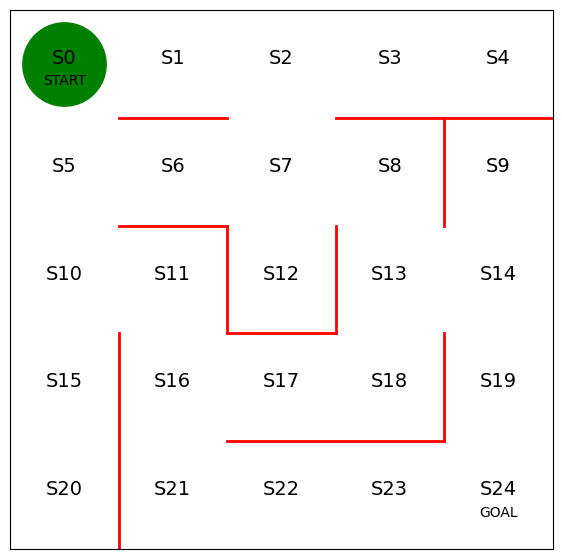

In [57]:
# 図の初期化

# 図の大きさと図の変数名
fig = plt.figure(figsize=(7, 7))
ax = plt.gca()

# 赤い壁
plt.plot([1, 2], [4, 4], color='red', linewidth=2)
plt.plot([3, 5], [4, 4], color='red', linewidth=2)
plt.plot([3, 3], [2, 3], color='red', linewidth=2)
plt.plot([1, 2], [3, 3], color='red', linewidth=2)
plt.plot([2, 3], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 3], color='red', linewidth=2)
plt.plot([4, 4], [4, 3], color='red', linewidth=2)
plt.plot([4, 4], [2, 1], color='red', linewidth=2)
plt.plot([2, 4], [1, 1], color='red', linewidth=2)
plt.plot([1, 1], [2, 0], color='red', linewidth=2)

# 状態を示す文字（S0~S24）
plt.text(0.5, 4.5, 'S0', size=14, ha='center')
plt.text(1.5, 4.5, 'S1', size=14, ha='center')
plt.text(2.5, 4.5, 'S2', size=14, ha='center')
plt.text(3.5, 4.5, 'S3', size=14, ha='center')
plt.text(4.5, 4.5, 'S4', size=14, ha='center')
plt.text(0.5, 3.5, 'S5', size=14, ha='center')
plt.text(1.5, 3.5, 'S6', size=14, ha='center')
plt.text(2.5, 3.5, 'S7', size=14, ha='center')
plt.text(3.5, 3.5, 'S8', size=14, ha='center')
plt.text(4.5, 3.5, 'S9', size=14, ha='center')
plt.text(0.5, 2.5, 'S10', size=14, ha='center')
plt.text(1.5, 2.5, 'S11', size=14, ha='center')
plt.text(2.5, 2.5, 'S12', size=14, ha='center')
plt.text(3.5, 2.5, 'S13', size=14, ha='center')
plt.text(4.5, 2.5, 'S14', size=14, ha='center')
plt.text(0.5, 1.5, 'S15', size=14, ha='center')
plt.text(1.5, 1.5, 'S16', size=14, ha='center')
plt.text(2.5, 1.5, 'S17', size=14, ha='center')
plt.text(3.5, 1.5, 'S18', size=14, ha='center')
plt.text(4.5, 1.5, 'S19', size=14, ha='center')
plt.text(0.5, 0.5, 'S20', size=14, ha='center')
plt.text(1.5, 0.5, 'S21', size=14, ha='center')
plt.text(2.5, 0.5, 'S22', size=14, ha='center')
plt.text(3.5, 0.5, 'S23', size=14, ha='center')
plt.text(4.5, 0.5, 'S24', size=14, ha='center')
plt.text(0.5, 4.3, 'START', ha='center')
plt.text(4.5, 0.3, 'GOAL', ha='center')

# 描画範囲と目盛り削除
ax.set_xlim(0, 5)
ax.set_ylim(0, 5)
ax.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)

# S0に緑色の丸を描画
line, = ax.plot([0.5], [4.5], marker='o', color='g', markersize=60)

In [58]:
# エージェントの移動の様子を可視化


def init():
    # 背景画像の初期化
    line.set_data([], [])
    return (line,)


def animate(i):
    # フレームごとの描画内容
    state = s_a_history[i][0]  # 現在の場所を描く
    x = (state % 5) + 0.5    # 状態のx座標は5で割った余り+0.5
    y = 4.5 - int(state / 5)    # y座標は5で割った商を4.5から引く
    line.set_data(x, y)
    
    return (line,)

# 初期化関数とフレームごとの描画関数を用いてアニメーションを作成
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(s_a_history), interval=200, repeat=False)

anim.save("../animation/move_robot.gif",writer='pillow')

display(HTML(anim.to_jshtml()))

※アニメーションが再生されない場合，[こちら](https://github.com/Ryusei-Baba/Advanced_Probabilistic_Robotics/blob/main/animation/move_robot.gif)をご覧ください．